In [1]:
# Importing relevant libraries, specially, Keras with tensorflow backend
# I would like to mention that for running and building this DNN regression model
# I had rent gpu servers from the paperspace.com

%matplotlib inline
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from keras.layers.normalization import BatchNormalization
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib

Using TensorFlow backend.


In [2]:
# checking if I am utilizing GPU
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
# LOADING SCALED TRAINING data which we created and saved in another notebook
train_df_scaled = pd.read_feather('nyc_taxi_TRAIN_std_Scaled_data.feather')

# Initially, I wanted to use the entire 55 million data, hence the renting of the gpu, However,
# Training the Deep Neural Network below was taking very long time and would have required atleast a week or more time
# of continous training :( Hence I decided to train on less amount of data. 1e+6 gave me a reasonable time for training,
# hence below I am getting the 1e+06 data points from the Full training set.

train_df_scaled_CUT = train_df_scaled[:1000000]
display(train_df_scaled_CUT.head())
train_df_scaled_CUT.shape

# spliting into training set (X) and target set (y)
X = train_df_scaled_CUT.drop(['fare_amount'], axis=1)
display(X.head())
y = train_df_scaled_CUT["fare_amount"]
display(y.head())

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour_of_day,year
0,-0.747181,3.313546,-0.931792,3.533124,-1.120772,-0.528808,0.535072,-1.466847
1,0.646017,-1.031476,-1.246457,-0.136169,0.880085,-0.528808,0.381630,-0.930737
2,-0.612355,-0.188686,0.323632,-0.455246,-0.022211,0.236251,-2.073428,-0.394626
3,-0.387646,-0.299874,-0.560187,-0.463991,0.193867,-0.528808,-1.459664,0.141484
4,-0.657297,0.181748,0.535446,0.466602,0.930547,-0.528808,-0.999340,-0.930737


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour_of_day,year
0,3.313546,-0.931792,3.533124,-1.120772,-0.528808,0.535072,-1.466847
1,-1.031476,-1.246457,-0.136169,0.880085,-0.528808,0.381630,-0.930737
2,-0.188686,0.323632,-0.455246,-0.022211,0.236251,-2.073428,-0.394626
3,-0.299874,-0.560187,-0.463991,0.193867,-0.528808,-1.459664,0.141484
4,0.181748,0.535446,0.466602,0.930547,-0.528808,-0.999340,-0.930737


0   -0.747181
1    0.646017
2   -0.612355
3   -0.387646
4   -0.657297
Name: fare_amount, dtype: float64

In [4]:
# splitting into training and validation set
x_train,x_test,y_train,y_test = train_test_split(X,y, test_size=0.20, random_state=42)
print(len(x_train))
print(X.shape[1])

800000
7


In [5]:
# DEEP NEURAL NETWORK ARCHITECTURE DEFINED HERE!

from keras.optimizers import Adam

model = Sequential()
model.add(Dense(units = 500, kernel_initializer='normal', activation = 'relu',input_dim = X.shape[1]))
model.add(Dropout(0.1))
model.add(Dense(units = 300, kernel_initializer='normal', activation = 'relu'))
model.add(Dense(units = 100, kernel_initializer='normal', activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(units = 50, kernel_initializer='normal', activation = 'relu'))
model.add(Dense(units = 1))

adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

model.compile(loss='mean_squared_error', optimizer=adam)
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=1,save_best_only=True) # save the best model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 500)               4000      
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 300)               150300    
_________________________________________________________________
dense_3 (Dense)              (None, 100)               30100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total para

In [6]:
# model fitting using the DNN defined above
# although here is shows epochs =10, However, I had previously ran for 50 epochs
# which took approx 5 hours for training, However, the results were similar and the validation loss
# didn't improve significantly after ~ 10 to 15 epochs

%%time
history = model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[checkpointer],verbose=1,epochs=10,
                    batch_size = 10)

Train on 800000 samples, validate on 200000 samples
Epoch 1/10
800000/800000 [==============================] - 371s 464us/step - loss: 0.1839 - val_loss: 0.1478

Epoch 00001: val_loss improved from inf to 0.14781, saving model to best_weights.hdf5
Epoch 2/10
800000/800000 [==============================] - 372s 465us/step - loss: 0.1539 - val_loss: 0.1390

Epoch 00002: val_loss improved from 0.14781 to 0.13896, saving model to best_weights.hdf5
Epoch 3/10
800000/800000 [==============================] - 372s 466us/step - loss: 0.1498 - val_loss: 0.1407

Epoch 00003: val_loss did not improve from 0.13896
Epoch 4/10
800000/800000 [==============================] - 372s 465us/step - loss: 0.1473 - val_loss: 0.1368

Epoch 00004: val_loss improved from 0.13896 to 0.13685, saving model to best_weights.hdf5
Epoch 5/10
800000/800000 [==============================] - 372s 465us/step - loss: 0.1455 - val_loss: 0.1384

Epoch 00005: val_loss did not improve from 0.13685
Epoch 6/10
800000/800000 

In [7]:
model.load_weights('best_weights.hdf5')# load weights from best model

In [9]:
# Predict and measure RMSE on the testing set obtained splitting the training set
pred = model.predict(x_test)
print(len(pred))
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

200000
Score (RMSE): 0.3606675018143043


[[-0.63045216]
 [-0.17516592]
 [-0.01056746]
 ...
 [-0.65152967]
 [-0.30069682]
 [-0.54284644]]


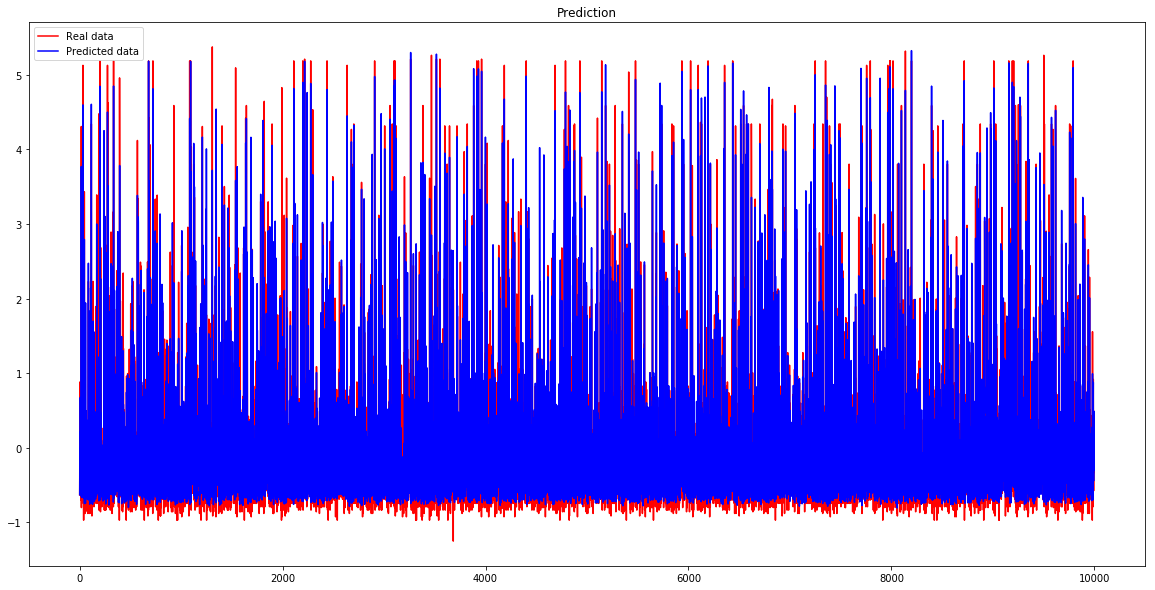

In [20]:
# COMPARISON between the real data and the predicted data. DNN set here seems to do reasonable job for fitting.
print(pred)
plt.figure(figsize=(20,10))
ytest_np = y_test.values
plt.plot(ytest_np[:10000], color = 'red', label = 'Real data')
plt.plot(pred[:10000], color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()

In [12]:
# LOADING the scaled testing data provided by the competition on kaggle for submitting predictions
test_df_PCA = pd.read_feather('nyc_taxi_TEST_std_Scaled_data.feather')
display(test_df_PCA.head())

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour_of_day,year
0,0.049519,0.403347,-0.193721,-0.215192,-0.528808,-0.078693,1.749816
1,-0.293118,-0.992567,-0.659017,-0.348189,-0.528808,-0.078693,1.749816
2,-0.183281,0.009087,-0.146337,-0.149077,-0.528808,-0.385575,-0.394626
3,-0.148920,0.529093,-0.434096,0.008657,-0.528808,1.148836,0.141484
4,0.233482,1.219438,-0.383866,-0.198226,-0.528808,1.148836,0.141484


In [13]:
# Predict on actual testing set
x_submission_test = test_df_PCA
pred_submission = model.predict(x_submission_test)
print(len(pred_submission))
print(pred_submission)

9914
[[-0.06070971]
 [ 0.00908503]
 [-0.6777363 ]
 ...
 [ 4.669705  ]
 [ 0.880932  ]
 [-0.42201373]]


In [14]:
# LOAD the scaler used before for scaling the fare_amount in the NY_taxi_Cleaning_Engineering_Scaling.ipynb notebook
scaler_filename = "scaler_fare.save"
# And now to load...
scaler_fare = joblib.load(scaler_filename) 

In [15]:
# inverse transform on the scaled 'pred_submission' prediction data, 
# utilizing the loaded scaler to obtain REAL $ predictions

rescaled_pred = scaler_fare.inverse_transform(pred_submission)
print(rescaled_pred)

[[10.609859 ]
 [11.23106  ]
 [ 5.1180844]
 ...
 [52.712383 ]
 [18.990835 ]
 [ 7.394114 ]]


In [16]:
# obtain testing set key from the previously (Cleaning.. notebook) saved dataframe.
test_df_ENG = pd.read_feather('nyc_taxi_data_TEST_ENG.feather')
columns = ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','passenger_count','hour_of_day','year']
test_df_key = test_df_ENG.drop(columns, 1)
display(test_df_key.head())

,key
0,2015-01-27 13:08:24.0000002
1,2015-01-27 13:08:24.0000003
2,2011-10-08 11:53:44.0000002
3,2012-12-01 21:12:12.0000002
4,2012-12-01 21:12:12.0000003


In [17]:
#Creating pandas dataframe from numpy array for testing set predictions
concatenate_arr = np.concatenate((test_df_key.values,rescaled_pred),axis=1)
submission_format = pd.DataFrame(concatenate_arr,columns = ['key','fare_amount'])

display(submission_format.head())

# Save final predictions and key to feather format
submission_format.to_feather('submission.feather')

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.6099
1,2015-01-27 13:08:24.0000003,11.2311
2,2011-10-08 11:53:44.0000002,5.11808
3,2012-12-01 21:12:12.0000002,7.35972
4,2012-12-01 21:12:12.0000003,14.1373


In [1]:
import pandas as pd

In [2]:
# convert dataframe for submitting predictions into the .csv format asked by the kaggle competition
load_submission = pd.read_feather('submission.feather')
load_submission.to_csv('submission.csv', index = False)